In [28]:
import bec4lib

In [22]:
import bec4fit

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [27]:
import importlib
importlib.reload(bec4lib)

<module 'bec4lib' from 'c:\\Users\\lazarus\\SPDF decay\\bec4lib.py'>

In [33]:
ids = np.arange(389531,389611+1)
imgs = bec4lib.queryImages(ids)
camInfo = bec4lib.queryImageSize(ids)
imgs = np.vstack(imgs)

In [34]:
dat = bec4lib.BEC4image(imgs,camInfo)
dat.dispersiveImage(pwaLoc = [2,3,4],knifeEdge=35,doPCA=True);

In [84]:
ncount = np.zeros((dat.shotsN))
doublon_mode = []
scan_var = []
for i in range(0,dat.shotsN):
    _,flag = bec4fit.findCloud(dat.absImg[i,5:-5,:])
    if flag == 0:
        #param,_ = bec4fit.fit_2DGaussian(dat.absImg[i,10:90,:])
        #ncount[i] = 2*np.pi*np.prod(param[2:5])
        ncount[i] = bec4fit.absImgNcount(dat.absImg[i,5:-5,:])
        doublon_mode.append(varlist1[i])
        scan_var.append(varlist2[i])
    else:
        print(f"empty shot detected, index {i}")
doublon_mode = np.array(doublon_mode)
scan_var = np.array(scan_var)

In [85]:
_, doublon_mode = np.unique(doublon_mode,return_inverse=True)
x_unique,_ = np.unique(varlist2, return_inverse=True)
all_atoms = []
kill_dbl = []
kill_pair = []
for x_val in x_unique:
    all_atoms.append(ncount[np.logical_and(doublon_mode==0,varlist2 == x_val)])
    kill_dbl.append(ncount[np.logical_and(doublon_mode==1,varlist2 == x_val)])
    kill_pair.append(ncount[np.logical_and(doublon_mode==2,varlist2 == x_val)])
    
dblFrac,spdf,dblerr,spdferr = bec4lib.doublonAnalysis(ncount,varlist1,varlist2)


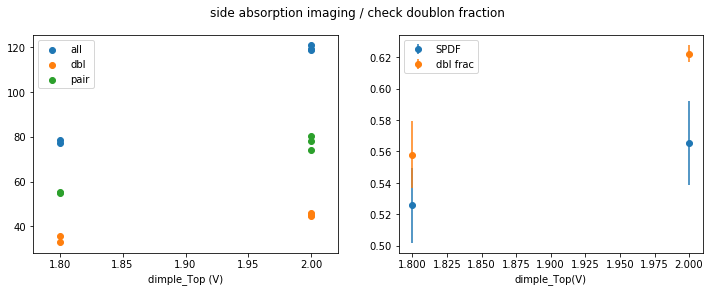

In [86]:
fig = plt.figure(figsize=(12,4))
fig.add_subplot(1,2,1)
plt.scatter(np.sort(scan_var[doublon_mode==0]),np.hstack(all_atoms),label='all')
plt.scatter(np.sort(scan_var[doublon_mode==1]),np.hstack(kill_dbl),label='dbl')
plt.scatter(np.sort(scan_var[doublon_mode==2]),np.hstack(kill_pair),label ='pair')
plt.legend()
plt.xlabel("dimple_Top (V)")

fig.add_subplot(1,2,2)
plt.errorbar(np.unique(varlist2),spdf,spdferr,fmt="o",label='SPDF')
plt.errorbar(np.unique(varlist2),dblFrac,dblerr,fmt="o",label='dbl frac')
plt.xlabel("dimple_Top(V)")
plt.legend()

plt.suptitle("side absorption imaging / check doublon fraction")
plt.savefig("oct_26_2020_check_dbl_frac.png")

### Dispersive image analysis

In [35]:
dat = bec4lib.BEC4image(imgs,camInfo)
dat.dispersiveImage(pwaLoc = [2,3,4],knifeEdge=35,doPCA=True);
varlist = bec4lib.queryVariable(ids,'Generic_Hold_Time')

In [36]:
ncount = np.zeros((dat.shotsN,3))
#doublon_mode = []
scan_var = []
for i in range(0,dat.shotsN):
    for j in range(0,3):
        popt,cutout = bec4fit.fit_2DGaussian(dat.pciImg[i,j])
        ncount[i,j] = 2*np.pi*np.prod(popt[2:5])
    scan_var.append(varlist[i])
scan_var = np.array(scan_var)

In [37]:
spdf_dat = bec4lib.spdf_jackknife(scan_var,ncount,flag=0)

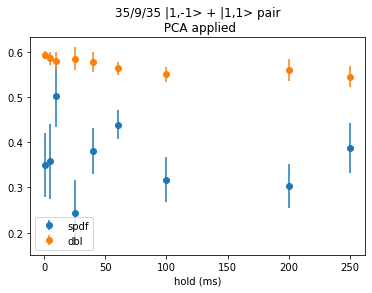

In [53]:
plt.errorbar(np.unique(scan_var),spdf_dat[:,1,0],yerr = spdf_dat[:,1,1],fmt='o',label='spdf')
plt.errorbar(np.unique(scan_var),spdf_dat[:,0,0],yerr = spdf_dat[:,0,1],fmt='o',label="dbl")
plt.xlabel("hold (ms)")
plt.legend()
plt.title("35/9/35 |1,-1> + |1,1> pair\n PCA applied")
plt.savefig("preliminary_positive-u.png")

In [54]:
dbls = (dat.pwa[:,0,:,:]-dat.pwa[:,2,:,:])/((dat.pwoa[:,0,:,:]+dat.pwoa[:,2,:,:])/2 - dat.dark[:,0,:,:])
alls = (dat.pwa[:,0]-dat.pwoa[:,0])/(dat.pwoa[:,0]-dat.dark[:,0])
killpairs = (dat.pwa[:,1]-dat.pwoa[:,1])/(dat.pwoa[:,1]-dat.dark[:,1])

In [55]:
ncount_dbl = np.zeros((dat.shotsN,1))
ncount_all = np.zeros((dat.shotsN,1))
ncount_killpairs = np.zeros((dat.shotsN,1))
for i in range(dat.shotsN):
    param2, _ = bec4fit.fit_2DGaussian(dbls[i])
    ncount_dbl[i] = 2*np.pi*np.prod(param2[2:5])
    param1, _ = bec4fit.fit_2DGaussian(alls[i])
    param3, _ = bec4fit.fit_2DGaussian(killpairs[i])
    ncount_killpairs[i] = 2*np.pi*np.prod(param3[2:5])
    ncount_all[i] = 2*np.pi*np.prod(param1[2:5])

ncount_array = np.hstack([ncount_all,ncount_killpairs,ncount_dbl])


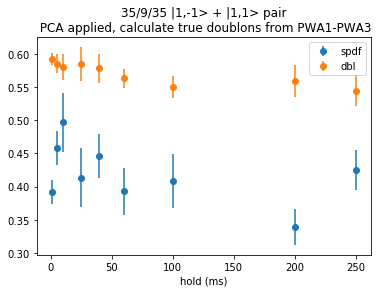

In [56]:
spdf_dat = bec4lib.spdf_jackknife(scan_var,ncount_array,flag=1)
plt.errorbar(np.unique(scan_var),spdf_dat[:,1,0],yerr = spdf_dat[:,1,1],fmt='o',label='spdf')
plt.errorbar(np.unique(scan_var),spdf_dat[:,0,0],yerr = spdf_dat[:,0,1],fmt='o',label="dbl")
plt.xlabel("hold (ms)")
plt.legend()
plt.title("35/9/35 |1,-1> + |1,1> pair\n PCA applied, calculate true doublons from PWA1-PWA3")
plt.savefig("preliminary_positive-u_v2.png")

In [62]:
ncount_killpairs[scan_var==10]

array([[13.39870937],
       [13.62876574],
       [11.98050858],
       [11.10014866],
       [13.28734292],
       [12.99926173],
       [11.62811877],
       [11.84914817],
       [13.23492249]])

In [42]:
dbls = (dat.pwa[:,0,:,:]-dat.pwa[:,2,:,:])/((dat.pwoa[:,0,:,:]+dat.pwoa[:,2,:,:])/2 - dat.dark[:,0,:,:])
alls = (dat.pwa[:,0]-dat.pwoa[:,0])/(dat.pwoa[:,0]-dat.dark[:,0])
pairs = (dat.pwa[:,0,:,:]-dat.pwa[:,1,:,:])/((dat.pwoa[:,0,:,:]+dat.pwoa[:,1,:,:])/2 - dat.dark[:,0,:,:])

In [43]:
ncount_dbl = np.zeros((dat.shotsN,1))
ncount_all = np.zeros((dat.shotsN,1))
ncount_pairs = np.zeros((dat.shotsN,1))
for i in range(dat.shotsN):
    param2, _ = bec4fit.fit_2DGaussian(dbls[i])
    ncount_dbl[i] = 2*np.pi*np.prod(param2[2:5])
    param1, _ = bec4fit.fit_2DGaussian(alls[i])
    param3, _ = bec4fit.fit_2DGaussian(pairs[i])
    ncount_all[i] = 2*np.pi*np.prod(param1[2:5])
    ncount_pairs[i] = 2*np.pi*np.prod(param3[2:5])

ncount_array = np.hstack([ncount_all,ncount_pairs,ncount_dbl])

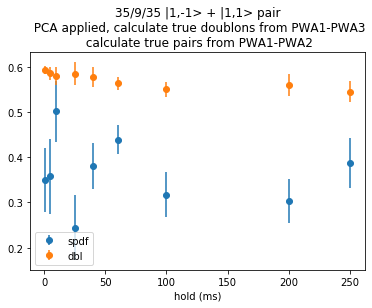

In [44]:
spdf_dat = bec4lib.spdf_jackknife(scan_var,ncount_array,flag=2)
plt.errorbar(np.unique(scan_var),spdf_dat[:,1,0],yerr = spdf_dat[:,1,1],fmt='o',label='spdf')
plt.errorbar(np.unique(scan_var),spdf_dat[:,0,0],yerr = spdf_dat[:,0,1],fmt='o',label="dbl")
plt.xlabel("hold (ms)")
plt.legend()
plt.title("35/9/35 |1,-1> + |1,1> pair\n PCA applied, calculate true doublons from PWA1-PWA3\n calculate true pairs from PWA1-PWA2")
plt.savefig("preliminary_positive-u_v3.png")

In [52]:
ncount_pairs[scan_var==1]

array([[4.27092135],
       [4.70583058],
       [4.73198819],
       [4.70484903],
       [5.77504421],
       [0.77105979],
       [0.77020579],
       [4.24498655],
       [0.67292923]])

In [48]:
scan_var

array([200., 200., 200., 200., 200., 200., 200., 200.,  10.,  10.,  10.,
        10.,  10.,  10.,  10.,  10.,  10.,  60.,  60.,  60.,  60.,  60.,
        60.,  60.,  60.,  60., 250., 250., 250., 250., 250., 250., 250.,
       250., 250., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
        40.,  40.,  40.,  40.,  40.,  40.,  40.,  40.,  40.,   5.,   5.,
         5.,   5.,   5.,   5.,   5.,   5.,   1.,   1.,   1.,   1.,   1.,
         1.,   1.,   1.,   1.,  25.,  25.,  25.,  25.,  25.,  25.,  25.,
        25.,  25.])